# Local Quickstart: Data Inspection and Outlier Detection with Obz AI 

Deep dive into Data Inspector functionality on natural images. We extract features from images that will be used to assess their data quality and to identify outliers.

In [ ]:
%pip install obzai

Firstly, let's start with importing necessary PyTorch modules.

In [90]:
from torchvision.datasets import Imagenette
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch

import numpy as np
import matplotlib.pyplot as plt

Next, let's prepare the datasets. In general, you will need two separate sets of images:

**Reference Dataset**: This dataset will be used to extract reference image features and to fit the outlier detection models. In ML, this may be a training dataset.

**Inference Dataset**: This dataset will be treated as incoming new data on which you want to perform outlier detection. In ML, this may be testing or validation dataset or any new samples in production.

For this tutorial, we will use a subset of the ImageNet dataset called **Imagenette**. The Reference data is from be the Imagenette training data, whereas the Inference data will be from the validation dataset.

In [3]:
# Transforms
TRANSFORMS = v2.Compose([v2.ToImage(), 
                         v2.ToDtype(torch.float32, scale=True), 
                         v2.CenterCrop(size=(160,160)),
                         v2.Resize(size=(224,224))])
NORMALIZE = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Datasets
train_ds = Imagenette(root="./example_data", split='train', size='160px', transform=TRANSFORMS, download=True)
ref_set = torch.utils.data.Subset(train_ds, indices=[i for i in range(0, len(train_ds), 10)])
val_ds = Imagenette(root="./example_data", split='val', size='160px', transform=TRANSFORMS)

# DataLoaders
ref_loader = DataLoader(ref_set, batch_size=32, shuffle=False)
inf_loader = DataLoader(val_ds, batch_size=6, shuffle=True)

# Labels mapping
CLASS_NAMES = ["tench", "English springer", "cassette player", 
               "chain saw", "church", "French horn", "garbage truck", 
               "gas pump", "golf ball", "parachute"]

LOGIT2NAME = {
    0: "tench",
    1: "English springer",
    2: "cassette player",
    3: "chain saw",
    4: "church",
    5: "French horn",
    6: "garbage truck",
    7: "gas pump",
    8: "golf ball",
    9: "parachute"
}

100%|██████████| 99.0M/99.0M [00:03<00:00, 25.1MB/s]


## Data Inspector Module Setup

You are now ready to create an Outlier Detector -- using the Reference dataset to obtain the typical distribution of visual features and applying that fitted model to the Inference dataset.

The Obz AI package is designed to be highly modular and customizable. As a first step, we’ll import the specific feature extractors and the outlier detection algorithm you want to use.

In [6]:
from obzai.data_inspector.extractor import FirstOrderExtractor, CLIPExtractor
from obzai.data_inspector.detector import GMMDetector, PCAReconstructionLossDetector

### First Order Extractor and GMM Detector

```FirstOrderExtractor``` is a straightforward and fast tool designed to extract first-order statistical features from images. These features summarize general properties of the pixel intensity values, such as mean, variance, skewness, etc. For example, they are useful for identifying images that are overly bright/dark or excessively variable in their intensities compared to the Reference dataset.

**Note:** First-order statistical features are invariant to the arrangement of pixels; in other words, they do not capture spatial relationships within the image.

At any point, you can view the list of features that ```FirstOrderExtractor``` computes by accessing its ```.feature_names``` attribute. This helps you to understand exactly which statistics are being extracted from your images.

In [7]:
first_order_extrc = FirstOrderExtractor()
first_order_extrc.feature_names

['entropy',
 'min',
 'max',
 '10th_percentile',
 '90th_percentile',
 'mean',
 'median',
 'interquartile_range',
 'range',
 'mean_absolute_deviation',
 'robust_mean_absolute_deviation',
 'root_mean_square',
 'skewness',
 'kurtosis',
 'variance',
 'uniformity']

`GMMDetector` is an outlier detection method that utilizes a Gaussian Mixture Model (GMM). To configure and use the `GMMDetector`, please follow the steps below:

* `extractors` - Sequence of Extractor objects which process your data. Currently, only the `FirstOrderExtractor` is accepted.
* `n_components` - A number of Gaussian components for the mixture model. This controls the complexity of the model and how finely it can separate data clusters.
* `outlier_quantile` - Set the quantile threshold to determine what is considered an outlier. Data points falling below this quantile are classified as outliers.
* `show_progress` - If set to `True`, a progress bar will be displayed during feature extraction to visualize operation progress.

After initialization, you can fit the model to your reference data by calling `.fit` method with a reference data. Ensure that the data you want to model comes in the form of a PyTorch `DataLoader` object.

In [8]:
gmm_detector = GMMDetector(extractors=[first_order_extrc], n_components=3, outlier_quantile=0.01, show_progress=True)
gmm_detector.fit(ref_loader)

Extracting features with FirstOrderExtractor: 100%|██████████| 30/30 [00:50<00:00,  1.68s/batch]


**That's all!** Your GMM based Outlier Detector is ready to use.

You can pass batches of images in the inference data into ```.detect()``` method. This method returns a named tuple with:

* ```img_features``` - extracted features for each image in the batch.
* ```outliers``` - boolean vector indicating if samples in the batch are outliers.

We can run this outlier detection on a single batch of images, and display the outputs.

In [80]:
# Example code to run inference on a single batch
image_batch, _ = next(iter(inf_loader))
detection_results = gmm_detector.detect(image_batch)

print("Outlier detection results for a batch:")
print(detection_results.outliers)

print("First Order Features for a batch:")
print(detection_results.img_features)

print("Detection scores:")
print(detection_results.scores)

Outlier detection results for a batch:
[False False False False False False]
First Order Features for a batch:
{'FirstOrderExtractor': array([[-0.1321358 , -0.21067457, -2.85866761, -0.96105929, -0.71928598,
        -1.33480387, -1.54948207,  0.28414261, -1.97234872,  0.23883897,
         0.26844519, -1.21498846,  0.70509588, -0.32887676, -0.05976168,
        -0.18264017],
       [ 0.49000959,  0.10122864, -0.07775944,  0.32109927,  0.4213851 ,
         0.31117897,  0.36743759, -0.28946286, -0.12170615, -0.25986486,
        -0.22655381,  0.20391615, -0.20428909, -0.36497599, -0.39398959,
        -0.26906024],
       [ 0.17032666, -0.15742302,  0.24412436,  0.19167228,  0.03662722,
         0.78998241,  1.04553002, -1.03965784,  0.28004634, -0.44526063,
        -0.56469952,  0.67078831, -1.31613405, -0.08586082, -0.4323126 ,
        -0.21751687],
       [ 0.59062427, -0.21067457, -0.82880913, -0.2339458 ,  0.30329166,
         0.58986454,  0.66964563, -0.14325218, -0.47665691, -0.019402

We can now run this outlier detection on ~1000 samples from the inference data 

In [56]:
## Example code to run inference on multiple batches (upto 1000 samples)
# Process multiple batches from the inference loader
firstorder_total_samples = 0
firstorder_total_outliers = 0
firstorder_outliers = []
firstorder_features = []
firstorder_scores = []

for batch_images, _ in inf_loader:
    # Process batch
    batch_results = gmm_detector.detect(batch_images)
    firstorder_total_outliers += batch_results.outliers.sum()
    firstorder_total_samples += len(batch_results.outliers)

    firstorder_outliers.append(batch_results.outliers.flatten())
    firstorder_features.append(batch_results.img_features['FirstOrderExtractor'].T)
    firstorder_scores.append(batch_results.scores.flatten())
    
    # Break after 1000 samples
    if firstorder_total_samples >= 1000:
        break

print(f"Processed {firstorder_total_samples} samples")
print(f"Found {firstorder_total_outliers} first-order outliers ({(firstorder_total_outliers/firstorder_total_samples)*100:.2f}%)")

Processed 1002 samples
Found 17 first-order outliers (1.70%)


We can visualize the results by creating a histogram of outlier status and a distribution of scores based on GMM. In the second figure, we are plotting the distributrion of scores with y-axis in a log scale.

/var/folders/df/265628290l5grbq5yxwtltj80000gn/T/ipykernel_38395/422559236.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


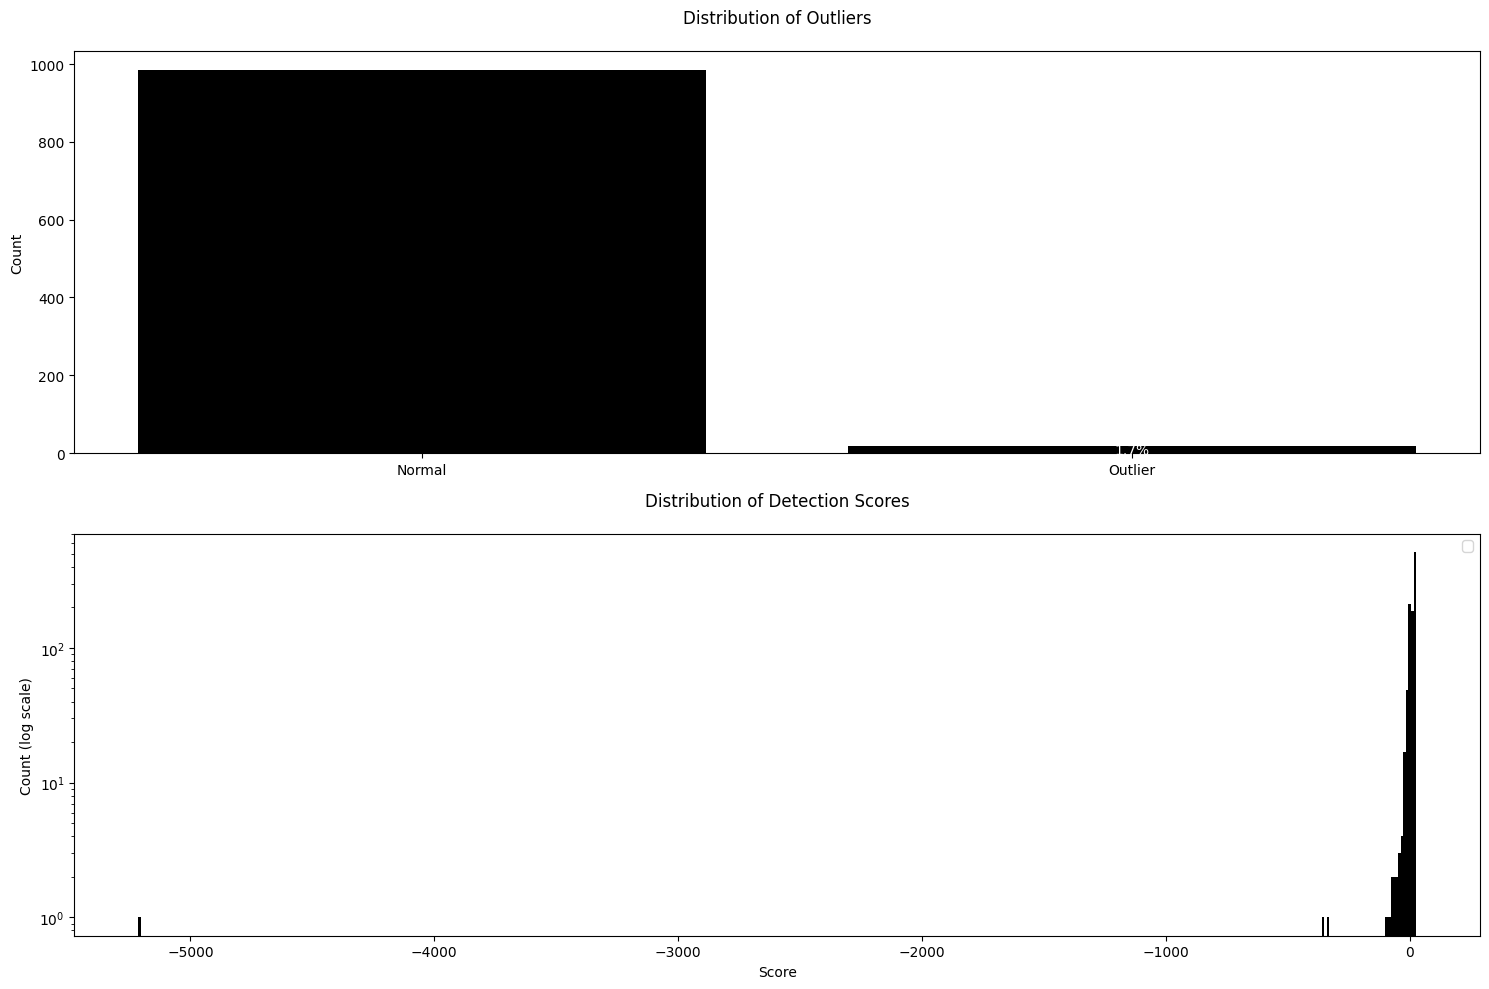

In [95]:
# Convert lists to numpy arrays for easier manipulation
firstorder_outliers_array = np.concatenate(firstorder_outliers)
firstorder_scores_array = np.concatenate(firstorder_scores)

# Calculate counts for normal and outlier samples
firstorder_outlier_counts = np.bincount(firstorder_outliers_array.astype(int))

# Create the same plots with a minimal look
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Outlier Status Histogram with minimal style
ax1.bar(['Normal', 'Outlier'], firstorder_outlier_counts, color='black')
ax1.set_title('Distribution of Outliers', pad=20)
ax1.set_ylabel('Count')
percentage = (firstorder_outlier_counts[1] / len(firstorder_outliers_array)) * 100
ax1.text(1, firstorder_outlier_counts[1]/2, f'{percentage:.1f}%', ha='center', va='center', color='white')

# Plot 2: Detection Scores Distribution with minimal style
ax2.hist(firstorder_scores_array, bins=500, color='black', edgecolor='none')
ax2.set_yscale('log')  # Set y-axis to logarithmic scale
ax2.set_title('Distribution of Detection Scores', pad=20)
ax2.set_xlabel('Score')
ax2.set_ylabel('Count (log scale)')
ax2.legend()

plt.tight_layout()
plt.show()

For completeness, it is good to visualize some images within the normal range and outside of the range. 

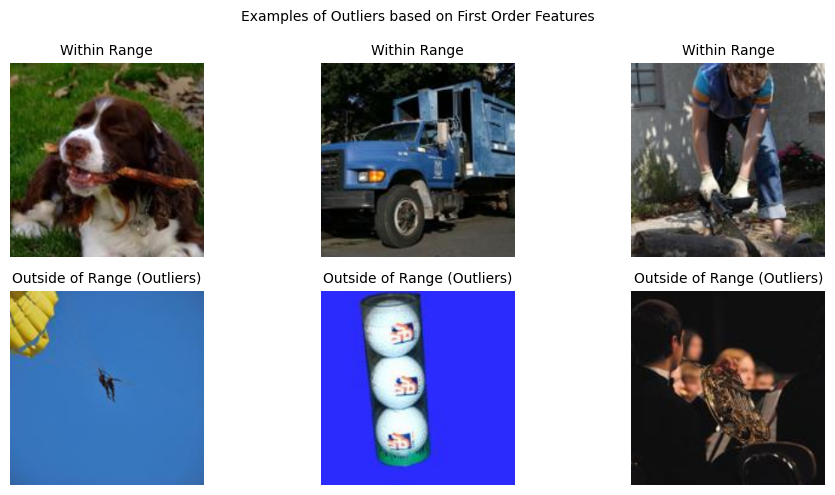

In [84]:
# Get first batch of outliers from scores and images
normal_images = []
outlier_images = []
batch_idx = 0

for batch_images, _ in inf_loader:
    detection_results = gmm_detector.detect(batch_images)
    
    # Add normal images
    normal_idx = (~detection_results.outliers).nonzero()[0]
    if len(normal_idx) > 0:
        for idx in normal_idx[:3-len(normal_images)]:
            if len(normal_images) < 3:
                normal_images.append(batch_images[idx].cpu().numpy())
    
    # Add outlier images
    outlier_idx = detection_results.outliers.nonzero()[0]
    if len(outlier_idx) > 0:
        for idx in outlier_idx[:3-len(outlier_images)]:
            if len(outlier_images) < 3:
                outlier_images.append(batch_images[idx].cpu().numpy())
    
    # Break if we have enough images
    if len(normal_images) == 3 and len(outlier_images) == 3:
        break
    
    batch_idx += 1

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 5))

# Plot normal images
for i, img in enumerate(normal_images):
    axes[0, i].imshow(img.transpose(1, 2, 0))
    axes[0, i].axis('off')
    axes[0, i].set_title('Within Range', fontsize=10)

# Plot outlier images
for i, img in enumerate(outlier_images):
    axes[1, i].imshow(img.transpose(1, 2, 0))
    axes[1, i].axis('off')
    axes[1, i].set_title('Outside of Range (Outliers)', fontsize=10)


plt.suptitle('Examples of Outliers based on First Order Features', fontsize=10)
plt.tight_layout()
plt.show()

### CLIP Extractor and PCA Reconstruction Loss Detector

`GMMDetector` applied on First Order Features provides a straightforward quantification that are invariant to the spatial arrangement of objects. 

We provide more advanced outlier detection based on principal component analysis (PCA), which are suitable for high dimensional embedding features. Here, we look at how to use a deep learning model (CLIP; Contrastive Language-Image Pre-training) to extract embedding features that take account for spatial relationships. To handle this type of high dimensional features, we use `PCAReconstructionLossDetector` as an outlier detection algorithm.

*There will an image schematic presentation of Reconstruction Loss idea.*

To set up the `PCAReconstructionLossDetector`, you need to provide the following arguments:

- **extractor**: This is an already-instantiated extractor object that will be used to turn images into feature vectors. It is best to use an extractor that outputs features with high dimensions, such as `CLIPExtractor`.
- **n_components**: This is the number of principal components (PCs). In other words, it controls how many dimensions will be in the reduced latent space.
- **outlier_quantile**: This value is used to decide if an image should be considered an outlier. If the reconstruction loss (the difference between the original and reconstructed image in feature space) for an image is higher than this quantile, then the detector will classify that image as an outlier.
- **show_progress**: Set this to `True` if you want to see a progress bar while features are being extracted. If you don’t want to see a progress bar, set it to `False`.

Note that unlike `GMMDetector`, `PCAReconstructionLossDetector` considers an unusually high value (e.g., reconstruction loss) to indicate evidence for an outlier.

In [51]:
clip_extractor = CLIPExtractor()
pca_detector = PCAReconstructionLossDetector(extractor=clip_extractor, n_components=128, outlier_quantile=0.01, show_progress=True)

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [52]:
pca_detector.fit(ref_loader)

Extracting features with CLIPExtractor:   0%|          | 0/30 [00:00<?, ?batch/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Extracting features with CLIPExtractor: 100%|██████████| 30/30 [00:16<00:00,  1.84batch/s]


After having fitted this outlier detection algorithm on our reference data, we can apply it on samples from the inference data.

In [55]:
## Example code to run inference on a single batch
# image_batch, _ = next(iter(inf_loader))
# detection_results = pca_detector.detect(image_batch)

# print("CLIP features:")
# print(detection_results.img_features)

# print("Outlier status:")
# print(detection_results.outliers)

# print("PCA Reconstruction Loss")
# print(detection_results.scores)

# print("2D PCA Components")
# print(detection_results.projector_results.pca_coords)

# print("2D UMAP Components")
# print(detection_results.projector_results.umap_coords)

## Example code to run inference on multiple batches (upto 1000 samples)
# Process multiple batches from the inference loader
clip_total_samples = 0
clip_total_outliers = 0
clip_outliers = []
clip_features = []
clip_scores = []

for batch_images, _ in inf_loader:
    # Process batch
    batch_results = pca_detector.detect(batch_images)
    clip_total_outliers += batch_results.outliers.sum()
    clip_total_samples += len(batch_results.outliers)

    clip_outliers.append(batch_results.outliers.flatten())
    clip_features.append(batch_results.img_features['CLIPExtractor'].T)
    clip_scores.append(batch_results.scores.flatten())
    
    # Break after 1000 samples
    if clip_total_samples >= 1000:
        break

print(f"Processed {clip_total_samples} samples")
print(f"Found {clip_total_outliers} outliers ({(clip_total_outliers/clip_total_samples)*100:.2f}%)")

Processed 1002 samples
Found 211 outliers (21.06%)


/var/folders/df/265628290l5grbq5yxwtltj80000gn/T/ipykernel_38395/2908118596.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


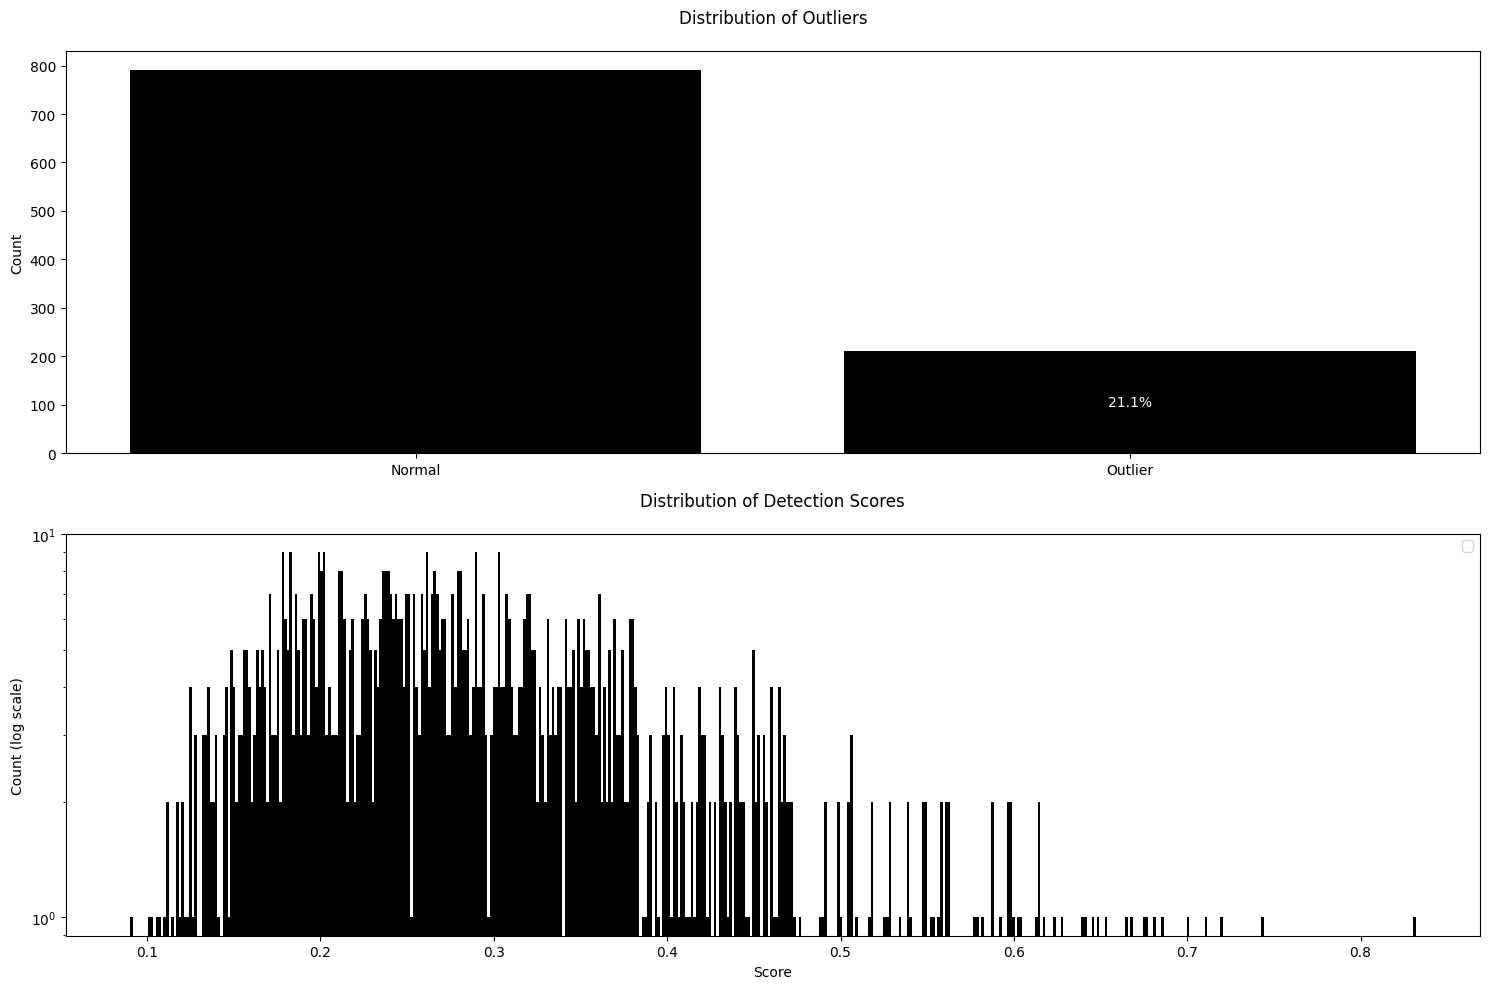

In [94]:
# Convert lists to numpy arrays for easier manipulation
clip_outliers_array = np.concatenate(clip_outliers)
clip_scores_array = np.concatenate(clip_scores)

# Calculate counts for normal and outlier samples
clip_outlier_counts = np.bincount(clip_outliers_array.astype(int))

# Create the same plots with a minimal look
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Outlier Status Histogram with minimal style
ax1.bar(['Normal', 'Outlier'], clip_outlier_counts, color='black')  
ax1.set_title('Distribution of Outliers', pad=20)
ax1.set_ylabel('Count')
percentage = (clip_outlier_counts[1] / len(clip_outliers_array)) * 100
ax1.text(1, clip_outlier_counts[1]/2, f'{percentage:.1f}%', ha='center', va='center', color='white')

# Plot 2: Detection Scores Distribution with minimal style
ax2.hist(clip_scores_array, bins=500, color='black', edgecolor='none')
ax2.set_yscale('log')  # Set y-axis to logarithmic scale
ax2.set_title('Distribution of Detection Scores', pad=20)
ax2.set_xlabel('Score')
ax2.set_ylabel('Count (log scale)')
ax2.legend()

plt.tight_layout()
plt.show()


In [93]:
clip_outlier_counts[1]/2

np.float64(105.5)

We can now visualize some of samples that are considered outliers by the CLIP-based detection method.

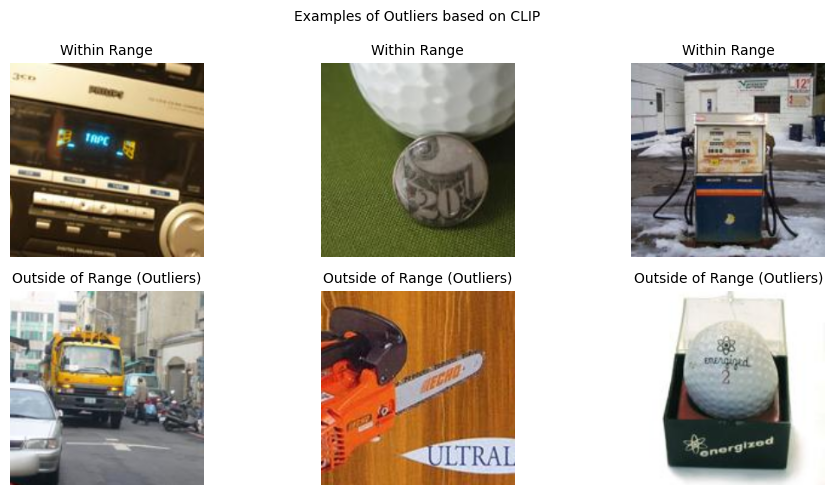

In [83]:
# Get first batch of outliers from scores and images
normal_images = []
outlier_images = []
batch_idx = 0

for batch_images, _ in inf_loader:
    detection_results = pca_detector.detect(batch_images)
    
    # Add normal images
    normal_idx = (~detection_results.outliers).nonzero()[0]
    if len(normal_idx) > 0:
        for idx in normal_idx[:3-len(normal_images)]:
            if len(normal_images) < 3:
                normal_images.append(batch_images[idx].cpu().numpy())
    
    # Add outlier images
    outlier_idx = detection_results.outliers.nonzero()[0]
    if len(outlier_idx) > 0:
        for idx in outlier_idx[:3-len(outlier_images)]:
            if len(outlier_images) < 3:
                outlier_images.append(batch_images[idx].cpu().numpy())
    
    # Break if we have enough images
    if len(normal_images) == 3 and len(outlier_images) == 3:
        break
    
    batch_idx += 1

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 5))

# Plot normal images
for i, img in enumerate(normal_images):
    axes[0, i].imshow(img.transpose(1, 2, 0))
    axes[0, i].axis('off')
    axes[0, i].set_title('Within Range', fontsize=10)

# Plot outlier images
for i, img in enumerate(outlier_images):
    axes[1, i].imshow(img.transpose(1, 2, 0))
    axes[1, i].axis('off')
    axes[1, i].set_title('Outside of Range (Outliers)', fontsize=10)

plt.suptitle('Examples of Outliers based on CLIP', fontsize=10)
plt.tight_layout()
plt.show()

### Inspecting reference features

When you fit an Outlier Detector, it internally extracts and stores a set of reference features from your data. If you wish to access these reference features for inspection or further analysis, you can do so easily.

Simply use the `.return_reference_features()` method on your detector instance. This method will return the reference features associated with the given detector.

Let’s see how to retrieve the reference features from a `GMMDetector` object:

In [85]:
refs_gmm = gmm_detector.return_reference_features()
refs_gmm.head()

,entropy,min,max,10th_percentile,90th_percentile,mean,median,interquartile_range,range,mean_absolute_deviation,robust_mean_absolute_deviation,root_mean_square,skewness,kurtosis,variance,uniformity
0,-0.560766,2.568559,0.014206,1.573796,-0.972889,0.288514,0.276114,-1.405755,-1.623846,-1.933004,-1.559709,-0.087472,-0.106594,0.180071,-1.762852,-0.166783
1,0.086647,-0.210675,0.244124,0.687330,-0.641463,-0.063468,-0.103301,-1.153816,0.313929,-1.124246,-1.176459,-0.283841,0.970675,0.659125,-0.986085,-0.224802
2,0.659640,-0.210675,0.244124,-1.100992,0.155809,-0.050300,0.172437,0.525958,0.313929,0.660009,0.523816,0.073015,-0.393367,-0.416766,0.700750,-0.230594
3,0.378598,-0.210675,0.244124,0.478439,-0.578334,-0.025317,-0.040212,-0.883330,0.313929,-0.977347,-0.956440,-0.243550,0.135132,0.078455,-0.974429,-0.251161
4,-0.931885,-0.210675,0.244124,-0.327680,1.491853,0.188670,-0.520654,2.152311,0.313929,1.931850,2.679710,0.560584,0.383116,-0.571436,2.187741,0.740369


Similary you can retrieve reference features from you PCA Reconstruction Loss Detector.

In [86]:
refs_pca = pca_detector.return_reference_features()
refs_pca

,clip_0,clip_1,clip_2,clip_3,clip_4,clip_5,clip_6,clip_7,clip_8,clip_9,...,clip_758,clip_759,clip_760,clip_761,clip_762,clip_763,clip_764,clip_765,clip_766,clip_767
0,-0.147278,-1.137970,-0.963050,0.070830,-0.660320,-0.622410,-0.437438,-0.005786,0.507400,1.555576,...,0.621777,1.010146,-0.951717,-1.295740,3.005757,0.349652,-0.694073,1.511778,-0.971707,0.926916
1,-0.656067,-1.168016,-0.786420,-0.178135,-0.089380,0.380839,-1.324671,-1.029315,-0.403648,0.601465,...,1.050633,-0.595764,1.135748,-0.844244,0.505536,1.554984,-0.756158,2.056455,1.125296,0.787142
2,0.656469,-0.542401,-1.609164,-0.536193,-0.718697,0.849094,-0.758182,-1.135488,-0.828077,1.024165,...,0.371950,2.467029,1.937310,0.713116,0.919189,0.296564,0.318553,2.134959,1.827570,-0.112840
3,-0.606947,-1.213291,-0.949584,-1.337959,-0.712596,0.492453,0.503168,-0.914174,0.401987,0.615202,...,-0.158715,0.677862,-0.248625,-0.438001,2.260302,1.502406,-0.260594,1.037295,-0.745743,0.026662
4,-0.136870,-0.706444,0.093599,0.388052,0.796189,-0.963762,-1.633851,-0.527316,-1.145183,1.414454,...,1.010016,1.537347,1.117910,-0.642881,-0.603352,0.041506,-1.170405,0.537562,1.221447,0.711063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,0.557009,0.357432,0.176850,-0.272175,-0.916979,1.528545,-1.540095,-0.522113,0.622676,0.336369,...,-0.927049,-0.642691,-1.884063,-0.954105,1.693890,0.446905,1.341081,0.930493,0.400819,-0.396868
943,0.786191,1.413359,0.325872,-1.083804,0.409204,3.101770,0.772388,1.859567,0.868511,-0.266364,...,-1.928535,-1.226156,-1.018645,-1.864901,1.413336,0.961148,0.300816,0.130768,-0.862399,1.191488
944,-0.443328,1.062377,1.226382,-1.625110,-0.485802,2.719492,0.655628,-0.643394,1.000408,1.941717,...,-1.346098,-0.450085,0.012624,-0.580526,1.718560,-0.670029,0.086728,-1.123574,-0.307342,1.897886
945,0.504858,1.256841,-0.527647,-1.735268,-0.568528,2.541349,-0.716330,-0.905890,1.550692,-0.166969,...,0.340487,-0.827572,-0.955236,-1.191575,1.028692,1.446144,0.476380,0.126862,0.257347,0.936435


This particular type of a detector produces also 2 dimensional represenations of data points prepared with PCA and UMAP algorithms. It is particularly usefull for visualization on scatter plot. You can return those embedded features by calling `.return_reference_2D_components()`

In [89]:
embedding_coords = pca_detector.return_reference_2D_components()
print("## PCA Coordinates of Reference Set ##")
print(embedding_coords.pca_coords)
print("## UMAP Coordinates of Reference Set ##")
print(embedding_coords.umap_coords)

## PCA Coordinates of Reference Set ##
        x_coor     y_coor
0     9.501494   7.013512
1    17.202290  12.576481
2    15.603800  10.027860
3    14.825594  10.396540
4    11.999342  10.963834
..         ...        ...
942   5.190470 -10.450700
943   6.155877 -10.435268
944   4.931119 -11.205107
945   7.275045 -11.389244
946   1.419314  -6.772340

[947 rows x 2 columns]
## UMAP Coordinates of Reference Set ##
        x_coor     y_coor
0     9.501342   7.013336
1    17.202326  12.576518
2    15.603857  10.027987
3    14.825516  10.396494
4    11.999347  10.963912
..         ...        ...
942   5.190484 -10.450880
943   6.155859 -10.435368
944   4.931139 -11.205077
945   7.275099 -11.389211
946   1.419346  -6.772443

[947 rows x 2 columns]
